In [1]:
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


In [5]:
%load_ext autoreload
%autoreload 2

import os
import torch
from torchvision import tv_tensors
from torchvision.datasets import CocoDetection
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.datasets import wrap_dataset_for_transforms_v2
from mercury_duckling.datasets.transforms import (
    Blobify,
    OneHotEncodeFromBlobs,
    ResizeLongestSideAndPad,
    Colormap,
    MinMaxNormalization,
    StandardizeTarget
)
from mercury_duckling.datasets import ThermalDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
transform = None
target_transform = None
transforms = v2.Compose(
    [
        v2.ToImage(),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (0), "others": 0}),
        # v2.RandomIoUCrop(),
        # v2.RandomHorizontalFlip(p=0.7),
        # ResizeByCoefficient(cfg.data.coeff),
        # MinMaxNormalization(),
        # Colormap(colormap="turbo"),
        # Blobify(),
        # OneHotEncodeFromBlobs(),
        ResizeLongestSideAndPad(target_size=(256, 320)),
        # v2.ClampBoundingBoxes(),
        StandardizeTarget(13),
        v2.ToDtype({tv_tensors.Image: torch.float32, "others": None}, scale=True),
    ]
)
root="../../data/BigThermal/Frieburg_test/day/ImagesRGB"
dataset = CocoDetection(
    root=root,
    annFile=os.path.join(root, "../driving.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset = wrap_dataset_for_transforms_v2(
    dataset,
    target_keys=["masks", "labels", "boxes", "image_id"]
)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [15]:
input, target = dataset[10]
print("Image ID:", target["image_id"])
print(
    "input shape:", input.shape, 
    "\ninput class:", type(input),
    "\ninput dtype:", input.dtype
)
print(
    "\ntarget shape:", target["masks"].shape,
    "\nnumber of targets:", len(target["boxes"]),
    "\ntarget class:", type(target["masks"]),
    "\ntarget dtype:", target["masks"].dtype
)

Image ID: 11
input shape: torch.Size([3, 650, 1920]) 
input class: <class 'torchvision.tv_tensors._image.Image'> 
input dtype: torch.uint8

target shape: torch.Size([14, 650, 1920]) 
number of targets: 11 
target class: <class 'torchvision.tv_tensors._mask.Mask'> 
target dtype: torch.uint8


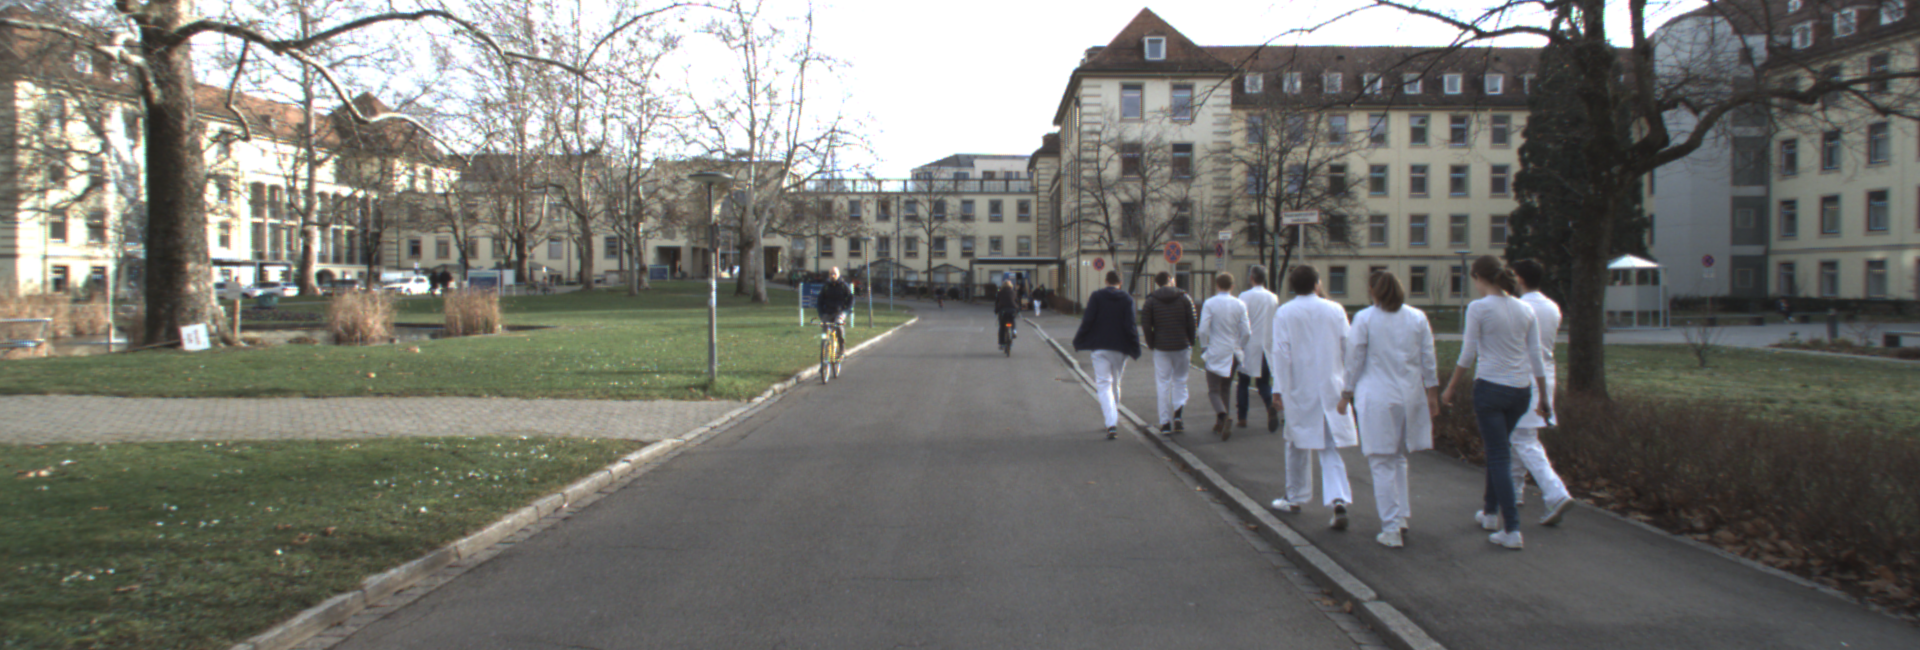

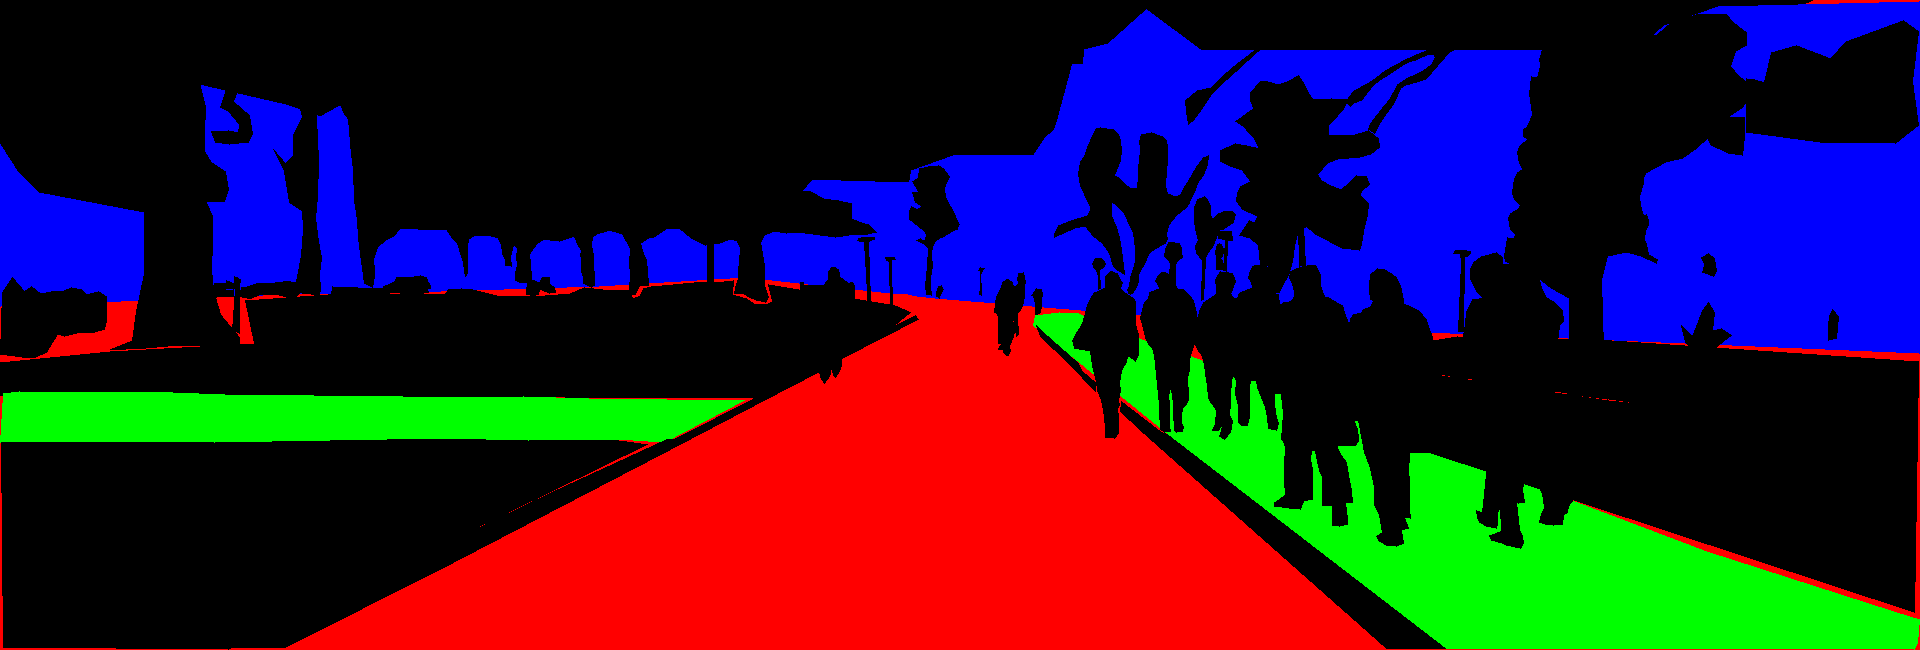

In [32]:
display(to_pil_image(input), to_pil_image(target["masks"][0:3].float()))